# Experiments with relation extraction

For the Filter Bubble project

## 1. Roberta Named Entity Recogntion by Erik Novak

Source: https://www.kaggle.com/eriknovak/pytorch-roberta-named-entity-recognition

In [1]:
# visualization libraries
import matplotlib.pyplot as plt
import numpy as np
import re

# pytorch libraries
import torch # the main pytorch library
import torch.nn as nn # the sub-library containing Softmax, Module and other useful functions
import torch.optim as optim # the sub-library containing the common optimizers (SGD, Adam, etc.)

# huggingface's transformers library
from transformers import RobertaForTokenClassification, RobertaTokenizer

# huggingface's datasets library
from datasets import load_dataset, Dataset, DatasetDict, Features, Value
from datasets.features import Sequence, ClassLabel

# the tqdm library used to show the iteration progress
import tqdm
tqdmn = tqdm.notebook.tqdm

In [2]:
roberta_version = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(roberta_version)

In [3]:
dataset = load_dataset("conll2003")

Reusing dataset conll2003 (/home/erikt/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6)


In [4]:
def read_data(file_name, ner_tag_ids):
    data = { "id": [], "tokens": [], "ner_tags": [] }
    tokens = []
    ner_tags = []
    infile = open(file_name, mode = "r", encoding = "latin1")
    for line in infile:
        if not re.search("^-DOCSTART-", line):
            try:
                token, pos_tag, ner_tag = line.split()
                if ner_tag not in ner_tag_ids:
                    ner_tag_ids[ner_tag] = len(ner_tag_ids)
                tokens.append(token)
                ner_tags.append(ner_tag_ids[ner_tag])
            except:
                if len(tokens) > 0:
                    data["id"].append(str(len(data["id"])))
                    data["tokens"].append(tokens)
                    data["ner_tags"].append(ner_tags)
                    ids = []
                    tokens = []
                    ner_tags = []
    if len(ids) > 0:
        data["id"].append(ids)
        data["tokens"].append(tokens)
        data["ner_tags"].append(ner_tags)
    infile.close()
    return [ data, ner_tag_ids ]

In [5]:
ner_tag_ids = {}
dutch_data_train, ner_tag_ids = read_data("ner/data/ned.train", ner_tag_ids)
dutch_data_validation, ner_tag_ids = read_data("ner/data/ned.testa", ner_tag_ids)
dutch_data_test, ner_tag_ids = read_data("ner/data/ned.testb", ner_tag_ids)

In [6]:
features_id = Value('string')
features_tokens = Sequence(Value('string'))
features_ner_tags = Sequence(ClassLabel(names=list(ner_tag_ids.keys())))
features = Features({"id": features_id, "tokens": features_tokens, "ner_tags": features_ner_tags })

In [7]:
dutch_data_converted = DatasetDict({ "train": Dataset.from_dict(dutch_data_train, features=features),
                                     "validation": Dataset.from_dict(dutch_data_validation, features=features),
                                     "test": Dataset.from_dict(dutch_data_test, features=features) })

In [8]:
num_labels = dutch_data_converted["train"].features['ner_tags'].feature.num_classes

In [9]:
def add_encodings(example):
    encodings = tokenizer(example['tokens'], truncation=True, padding='max_length', is_split_into_words=True)
    labels = example['ner_tags'] + [0] * (tokenizer.model_max_length - len(example['ner_tags']))
    return { **encodings, 'labels': labels }

In [10]:
dutch_data_converted = dutch_data_converted.map(add_encodings)

In [11]:
dutch_data_converted.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [12]:
labels = dutch_data_converted['train'].features['ner_tags'].feature
label2id = { k: labels.str2int(k) for k in labels.names }
id2label = { v: k for k, v in label2id.items() }

In [13]:
model = RobertaForTokenClassification.from_pretrained(roberta_version, num_labels=num_labels)
model.config.id2label = id2label
model.config.label2id = label2id

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
model.train().to(device)
optimizer = optim.AdamW(params=model.parameters(), lr=1e-5)

In [16]:
n_epochs = 1
train_data = torch.utils.data.DataLoader(dutch_data_converted['validation'], batch_size=4)

In [17]:
train_loss = []
for epoch in tqdmn(range(n_epochs)):
    current_loss = 0
    for i, batch in enumerate(tqdmn(train_data)):
        if i >= 100:
            break
        batch = { k: v.to(device) for k, v in batch.items() }
        outputs = model(**batch)
        loss = outputs[0]
        loss.backward()
        current_loss += loss.item()
        if i % 8 == 0 and i > 0:
            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(current_loss / 32)
            current_loss = 0
    optimizer.step()
    optimizer.zero_grad()

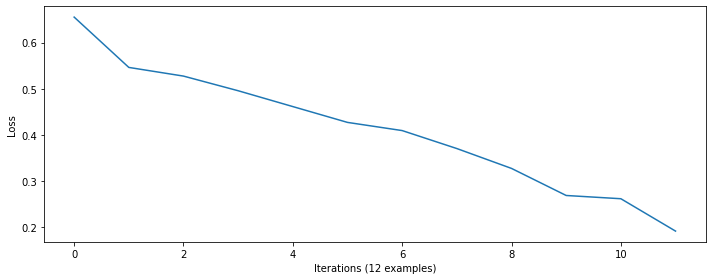

In [18]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(train_loss)
ax.set_ylabel('Loss')
ax.set_xlabel(f'Iterations ({len(train_loss)} examples)')
fig.tight_layout()
plt.show()

In [19]:
model = model.eval()
test_data = torch.utils.data.DataLoader(dutch_data_converted['test'], batch_size=4)

In [20]:
confusion = torch.zeros(num_labels, num_labels)
found = 0
missed = 0
wrong = 0

for i, batch in enumerate(tqdmn(test_data)):
    if i >= 100:
        break
    with torch.no_grad():
        batch = { k: v.to(device) for k, v in batch.items() }
        outputs = model(**batch)
            
    s_lengths = batch['attention_mask'].sum(dim=1)
    for idx, length in enumerate(s_lengths):
        true_values = batch['labels'][idx][:length]
        pred_values = torch.argmax(outputs[1], dim=2)[idx][:length]
        for true, pred in zip(true_values, pred_values):
            confusion[true.item()][pred.item()] += 1
            if true.item() > 0:
                if pred.item() > 0:
                    found += 1
                else: 
                    missed += 1
            elif pred.item() > 0:
                wrong += 1

In [21]:
if found + wrong == 0:
    precision = 0.0
else:
    precision = found / (found + wrong)
recall = found / (found + missed)

print(f"precision: {precision}; recall: {recall}")

precision: 0.0; recall: 0.0


In [22]:
for i in range(num_labels):
    confusion[i] = confusion[i] / confusion[i].sum()

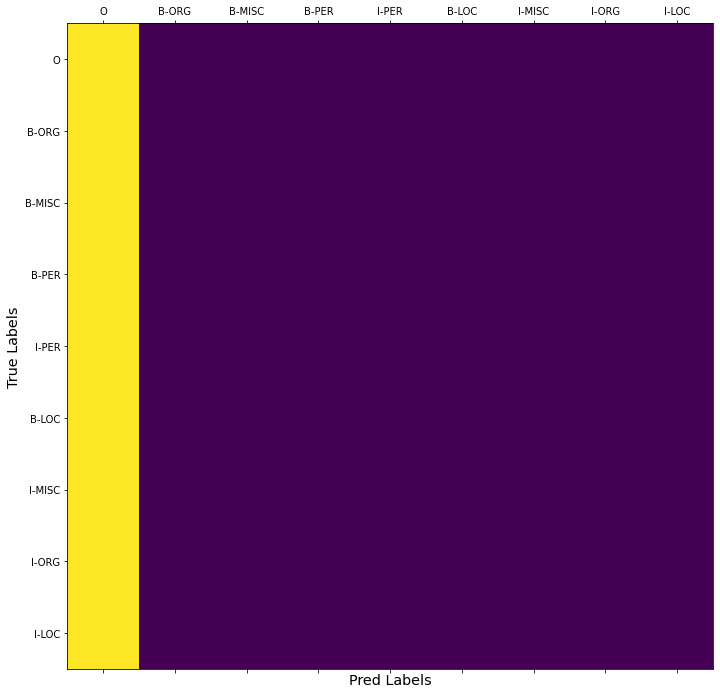

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confusion.numpy())

labels = list(label2id.keys())
ids = np.arange(len(labels))

ax.set_ylabel('True Labels', fontsize='x-large')
ax.set_xlabel('Pred Labels', fontsize='x-large')

ax.set_xticks(ids)
ax.set_xticklabels(labels)

ax.set_yticks(ids)
ax.set_yticklabels(labels)

fig.tight_layout()
plt.show()

In [24]:
confusion.numpy()

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [25]:
ner_tag_ids

{'O': 0,
 'B-ORG': 1,
 'B-MISC': 2,
 'B-PER': 3,
 'I-PER': 4,
 'B-LOC': 5,
 'I-MISC': 6,
 'I-ORG': 7,
 'I-LOC': 8}

## 2. SemEval-2016 Task 6

Source: https://alt.qcri.org/semeval2016/task6/

In [26]:
import pandas as pd

In [45]:
train_data = pd.read_csv("../data/StanceDataset/train_with_newlines.csv", encoding="latin1")

In [46]:
train_data

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos
...,...,...,...,...,...
2909,"There's a law protecting unborn eagles, but no...",Legalization of Abortion,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
2910,I am 1 in 3... I have had an abortion #Abortio...,Legalization of Abortion,AGAINST,2. The tweet does NOT expresses opinion about ...,other
2911,How dare you say my sexual preference is a cho...,Legalization of Abortion,AGAINST,2. The tweet does NOT expresses opinion about ...,neg
2912,"Equal rights for those 'born that way', no rig...",Legalization of Abortion,AGAINST,2. The tweet does NOT expresses opinion about ...,neg


In [48]:
train_data['Target'].value_counts()

Hillary Clinton                     689
Feminist Movement                   664
Legalization of Abortion            653
Atheism                             513
Climate Change is a Real Concern    395
Name: Target, dtype: int64

Next: text classification, see: https://mccormickml.com/2019/07/22/BERT-fine-tuning/